# Trabajo Final - Redes Neuronales

## Importo las librerias necesarias


In [1]:
from autoencoder import *
from clasificador import *

## Red neuronal autoencoder convolucional de varias capas

### Importo data set

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=True,  transform=transform)
valid_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=False, transform=transform)

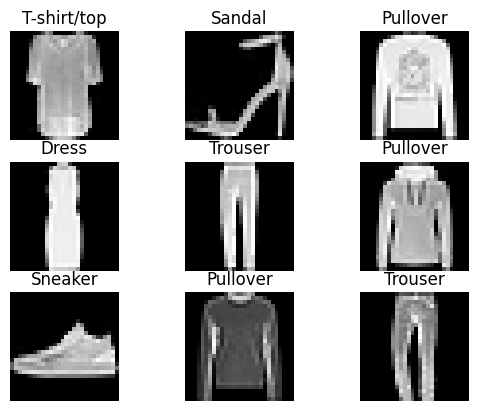

In [3]:
figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set_orig), size=(1,)).item()
    image, label = train_set_orig[j]
    figure.add_subplot(rows, cols, i)
    plt.title(train_set_orig.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Creo data set personalizado

In [4]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

### Parte 1: red autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            # Convolucional 1
            nn.Conv2d(1, 16, kernel_size=3),  # 1x28x28 -> 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2), # 16x26x26 -> 16x13x13
            # Convolucional 2
            nn.Conv2d(16, 32, kernel_size=3),  # 16x13x13 -> 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),  # 32x11x11 -> 32x5x5
            # Linear
            nn.Flatten(),  # 32x5x5 -> 32*5*5
            nn.Linear(32*5*5, n),  # fully connected 32*5*5 -> n
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.decoder = nn.Sequential(
            # Linear
            nn.Linear(n, 32*5*5),  # fully connected n -> 32*5*5
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32,5,5)),  # 32*5*5 -> 32x5x5
            # Convolucional transpose (de la segunda convolucional)
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, output_padding=1),  # 32x5x5 -> 16x13x13
            nn.ReLU(),
            nn.Dropout(p),
            # Convolucional transpose (de la primera convolucional)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1),  # 16x13x13 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Modelo sin entrenar

In [6]:
# 2.6)
n = 64
p = 0.2
autoencoder_conv = Autoencoder(n, p)
model = autoencoder_conv

In [7]:
autoencoder_conv.encoder

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [8]:
autoencoder_conv.decoder

Sequential(
  (0): Linear(in_features=64, out_features=800, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Unflatten(dim=1, unflattened_size=(32, 5, 5))
  (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (8): Sigmoid()
)

In [9]:
def batch(x):
    return x.unsqueeze(0)  # 28x28 -> 1x28x28


def unbatch(x):
    return x.squeeze().detach().cpu().numpy()  # 1x28x28 -> 28x28

In [10]:
image, _ = train_set[0]
pred = model(batch(image))
print(image.size())
print(unbatch(pred).shape)
print(pred.size())
print(unbatch(pred).shape)

torch.Size([1, 28, 28])
(28, 28)
torch.Size([1, 1, 28, 28])
(28, 28)


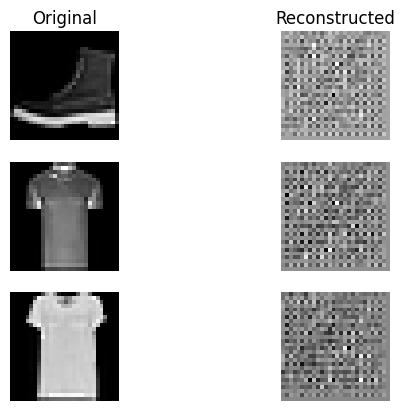

In [11]:
# miramos que imagene predice el modelo sin entrenar
figure = plt.figure()
rows, cols = 3, 2
i = 0
for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Original')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Reconstructed')
    plt.axis("off")
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred.squeeze(), cmap="gray")
plt.show()

## Parte 2: entrenenado el autoencoder

### Modelo Base

In [12]:
indices = torch.randint(len(valid_set), size=(3,))
indices

tensor([9310, 8757, 5363])

Epoch 1
-------------------------------
batch=0 loss=0.196896  muestras-procesadas:[    0/60000]
batch=100 loss=0.089689  muestras-procesadas:[10000/60000]
batch=200 loss=0.068279  muestras-procesadas:[20000/60000]
batch=300 loss=0.058437  muestras-procesadas:[30000/60000]
batch=400 loss=0.055645  muestras-procesadas:[40000/60000]
batch=500 loss=0.050685  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.049904 

Valid Error: Avg loss: 0.049923 

Epoch 2
-------------------------------
batch=0 loss=0.048801  muestras-procesadas:[    0/60000]
batch=100 loss=0.050890  muestras-procesadas:[10000/60000]
batch=200 loss=0.047039  muestras-procesadas:[20000/60000]
batch=300 loss=0.047877  muestras-procesadas:[30000/60000]
batch=400 loss=0.045352  muestras-procesadas:[40000/60000]
batch=500 loss=0.043014  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.043414 

Valid Error: Avg loss: 0.043455 

Epoch 3
-------------------------------
batch=0 loss=0.043093  muestras-procesad

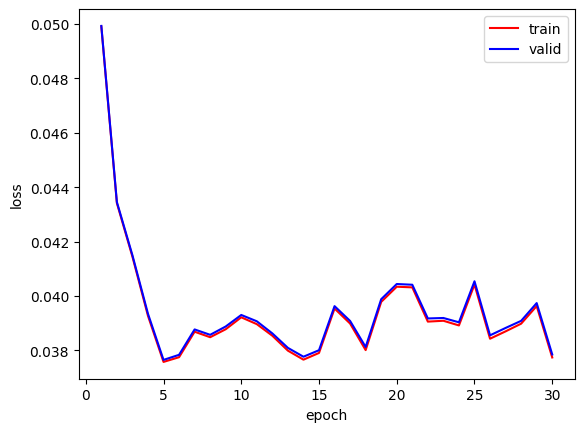

In [13]:
model_orig = model_generator(
    Autoencoder, 64, 0.2, 30, 100, 'Adam', 1e-3, train_set, valid_set)

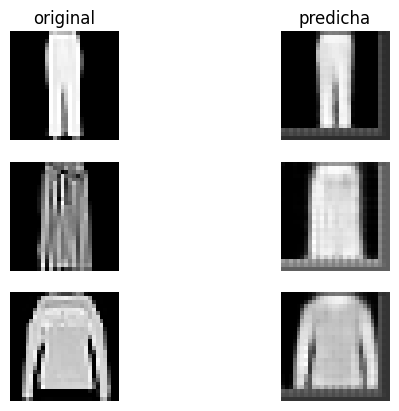

In [14]:
test_model(model_orig, valid_set, indices)

## Variar algunos parametros

### vario dropout

Epoch 1
-------------------------------
batch=0 loss=0.149580  muestras-procesadas:[    0/60000]
batch=100 loss=0.096062  muestras-procesadas:[10000/60000]
batch=200 loss=0.078649  muestras-procesadas:[20000/60000]
batch=300 loss=0.064021  muestras-procesadas:[30000/60000]
batch=400 loss=0.067976  muestras-procesadas:[40000/60000]
batch=500 loss=0.065574  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.076837 

Valid Error: Avg loss: 0.076709 

Epoch 2
-------------------------------
batch=0 loss=0.062301  muestras-procesadas:[    0/60000]
batch=100 loss=0.057825  muestras-procesadas:[10000/60000]
batch=200 loss=0.058194  muestras-procesadas:[20000/60000]
batch=300 loss=0.058415  muestras-procesadas:[30000/60000]
batch=400 loss=0.054566  muestras-procesadas:[40000/60000]
batch=500 loss=0.056688  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.073944 

Valid Error: Avg loss: 0.073895 

Epoch 3
-------------------------------
batch=0 loss=0.054952  muestras-procesad

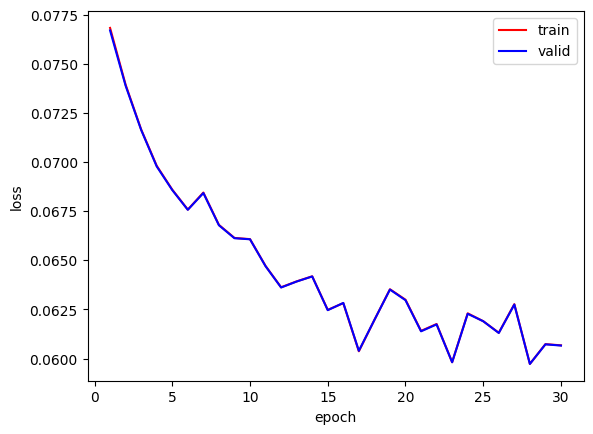

In [15]:
model_drop05 = model_generator(
    Autoencoder, 64, 0.5, 30, 100, 'Adam', 1e-3, train_set, valid_set)

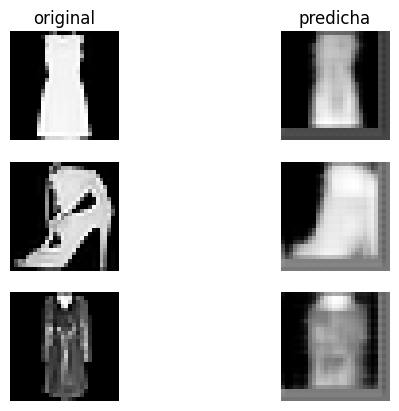

In [16]:
test_model(model_drop05, valid_set)

Epoch 1
-------------------------------
batch=0 loss=0.201625  muestras-procesadas:[    0/60000]
batch=100 loss=0.101665  muestras-procesadas:[10000/60000]
batch=200 loss=0.071449  muestras-procesadas:[20000/60000]
batch=300 loss=0.062422  muestras-procesadas:[30000/60000]
batch=400 loss=0.054842  muestras-procesadas:[40000/60000]
batch=500 loss=0.054103  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.047263 

Valid Error: Avg loss: 0.047279 

Epoch 2
-------------------------------
batch=0 loss=0.050474  muestras-procesadas:[    0/60000]
batch=100 loss=0.050464  muestras-procesadas:[10000/60000]
batch=200 loss=0.049861  muestras-procesadas:[20000/60000]
batch=300 loss=0.047649  muestras-procesadas:[30000/60000]
batch=400 loss=0.042858  muestras-procesadas:[40000/60000]
batch=500 loss=0.044460  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.040765 

Valid Error: Avg loss: 0.040820 

Epoch 3
-------------------------------
batch=0 loss=0.046175  muestras-procesad

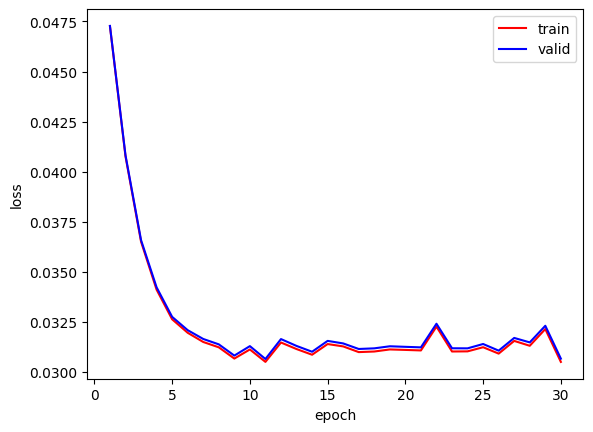

In [17]:
model_64_drop01 = model_generator(
    Autoencoder, 64, 0.1, 30, 100, 'Adam', 1e-3, train_set, valid_set)

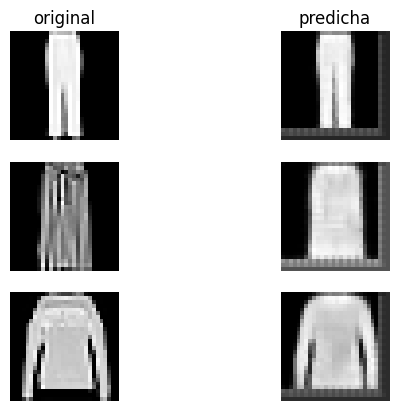

In [18]:
test_model(model_64_drop01, valid_set, indices)

Epoch 1
-------------------------------
batch=0 loss=0.147935  muestras-procesadas:[    0/60000]
batch=100 loss=0.060232  muestras-procesadas:[10000/60000]
batch=200 loss=0.049997  muestras-procesadas:[20000/60000]
batch=300 loss=0.044616  muestras-procesadas:[30000/60000]
batch=400 loss=0.038982  muestras-procesadas:[40000/60000]
batch=500 loss=0.037887  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.036005 

Valid Error: Avg loss: 0.036110 

Epoch 2
-------------------------------
batch=0 loss=0.038329  muestras-procesadas:[    0/60000]
batch=100 loss=0.035367  muestras-procesadas:[10000/60000]
batch=200 loss=0.033843  muestras-procesadas:[20000/60000]
batch=300 loss=0.033503  muestras-procesadas:[30000/60000]
batch=400 loss=0.032378  muestras-procesadas:[40000/60000]
batch=500 loss=0.031543  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.031535 

Valid Error: Avg loss: 0.031667 

Epoch 3
-------------------------------
batch=0 loss=0.031048  muestras-procesad

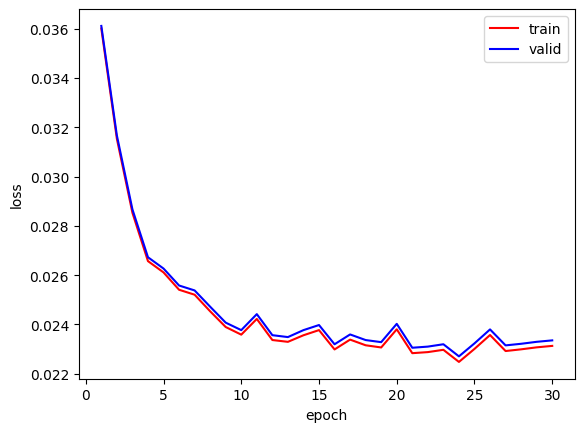

In [19]:
model_256_drop01 = model_generator(
    Autoencoder, 256, 0.1, 30, 100, 'Adam', 1e-3, train_set, valid_set)

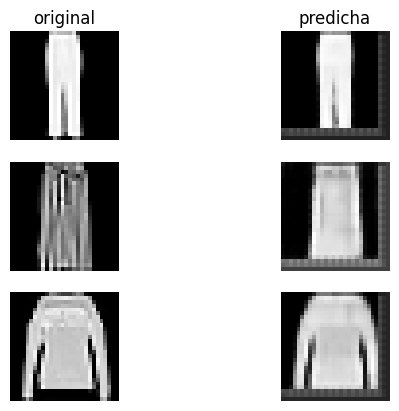

In [20]:
test_model(model_256_drop01, valid_set, indices)

### Variando optimizador

Epoch 1
-------------------------------
batch=0 loss=0.162980  muestras-procesadas:[    0/60000]
batch=100 loss=0.160882  muestras-procesadas:[10000/60000]
batch=200 loss=0.160766  muestras-procesadas:[20000/60000]
batch=300 loss=0.155534  muestras-procesadas:[30000/60000]
batch=400 loss=0.159385  muestras-procesadas:[40000/60000]
batch=500 loss=0.160407  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.157024 

Valid Error: Avg loss: 0.156325 

Epoch 2
-------------------------------
batch=0 loss=0.158220  muestras-procesadas:[    0/60000]
batch=100 loss=0.158736  muestras-procesadas:[10000/60000]
batch=200 loss=0.157990  muestras-procesadas:[20000/60000]
batch=300 loss=0.148236  muestras-procesadas:[30000/60000]
batch=400 loss=0.153056  muestras-procesadas:[40000/60000]
batch=500 loss=0.152023  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.152020 

Valid Error: Avg loss: 0.151345 

Epoch 3
-------------------------------
batch=0 loss=0.151331  muestras-procesad

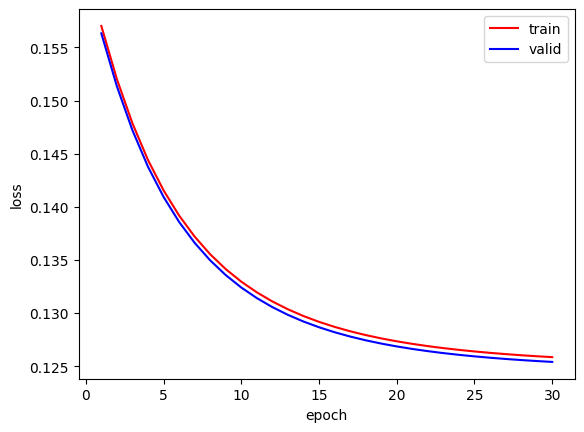

In [21]:
model_drop01_sgd = model_generator(
    Autoencoder, 64, 0.2, 30, 100, 'SGD', 1e-3, train_set, valid_set)

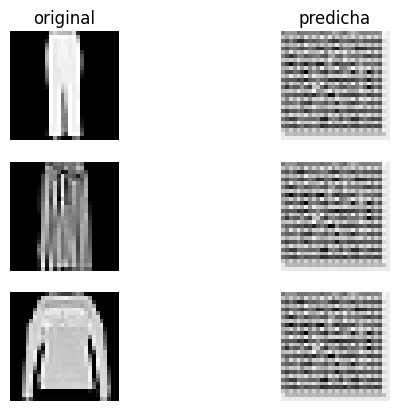

In [22]:
test_model(model_drop01_sgd, valid_set, indices)

## Parte 3: Definiendo un clasificador convolucional reutilizando el encoder

In [23]:
import copy


class Classifier_Conv(nn.Module):
    def __init__(self, n, encoder, p=0.2):
        super(Classifier_Conv, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = copy.deepcopy(encoder)
        self.classifier = nn.Sequential(
            # Linear
            nn.Linear(n, 10),  # fully connected n -> 32*5*5
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### clasificador usando el modelo original

Epoch 1
-------------------------------
batch=0 loss=2.843985  muestras-procesadas:[    0/60000]
batch=100 loss=1.003671  muestras-procesadas:[10000/60000]
batch=200 loss=0.497185  muestras-procesadas:[20000/60000]
batch=300 loss=0.575545  muestras-procesadas:[30000/60000]
batch=400 loss=0.649236  muestras-procesadas:[40000/60000]
batch=500 loss=0.519334  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.502334 

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.520750 

Epoch 2
-------------------------------
batch=0 loss=0.355933  muestras-procesadas:[    0/60000]
batch=100 loss=0.384717  muestras-procesadas:[10000/60000]
batch=200 loss=0.455006  muestras-procesadas:[20000/60000]
batch=300 loss=0.522340  muestras-procesadas:[30000/60000]
batch=400 loss=0.606431  muestras-procesadas:[40000/60000]
batch=500 loss=0.491892  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.423195 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.444043 

Epoch 3


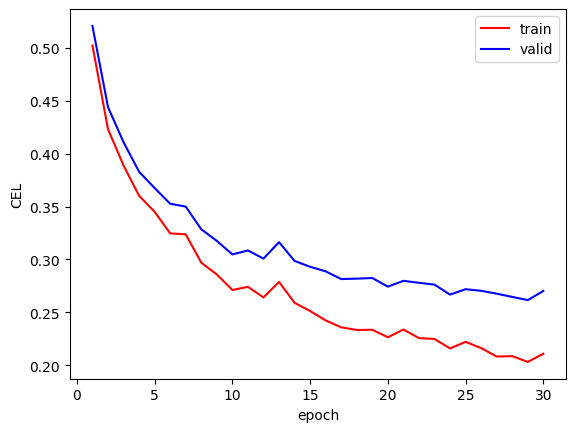

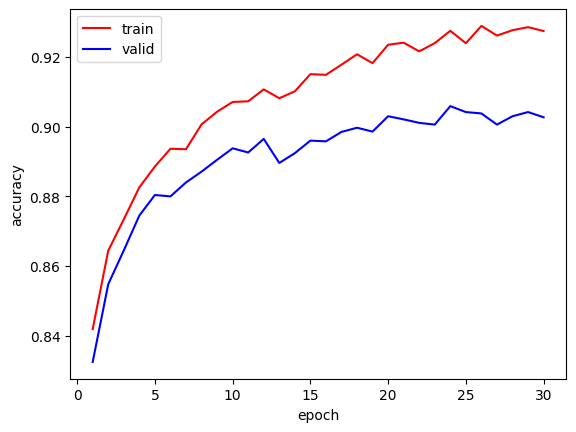

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int8)


              precision    recall  f1-score   support

     T-Shirt       0.83      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.83      0.86      0.85      1000
       Dress       0.89      0.92      0.90      1000
        Coat       0.90      0.79      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.72      0.71      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle Boot       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



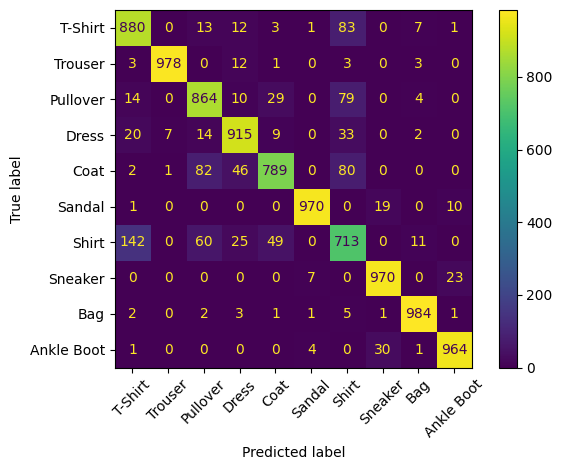

In [24]:
model_classifier_orig = classifier_generator(
    Classifier_Conv, 64, model_orig, 0.2, 30, 100, 'Adam', 1e-3, train_set_orig, valid_set_orig)

## Parte 4:

## Entrenando solo la capa clasificadora

Epoch 1
-------------------------------
batch=0 loss=2.528774  muestras-procesadas:[    0/60000]
batch=100 loss=1.486909  muestras-procesadas:[10000/60000]
batch=200 loss=1.258957  muestras-procesadas:[20000/60000]
batch=300 loss=1.212541  muestras-procesadas:[30000/60000]
batch=400 loss=0.885864  muestras-procesadas:[40000/60000]
batch=500 loss=0.747391  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.904598 

Test Error: 
 Accuracy: 76.1%, Avg loss: 0.918505 

Epoch 2
-------------------------------
batch=0 loss=0.822023  muestras-procesadas:[    0/60000]
batch=100 loss=1.023123  muestras-procesadas:[10000/60000]
batch=200 loss=0.658906  muestras-procesadas:[20000/60000]
batch=300 loss=0.861583  muestras-procesadas:[30000/60000]
batch=400 loss=0.684231  muestras-procesadas:[40000/60000]
batch=500 loss=0.634804  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.788416 

Test Error: 
 Accuracy: 77.3%, Avg loss: 0.803521 

Epoch 3


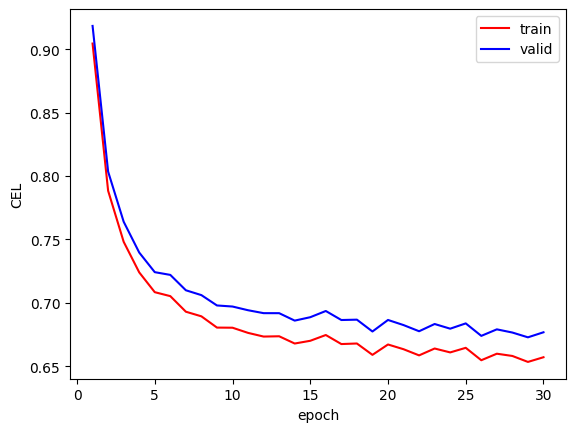

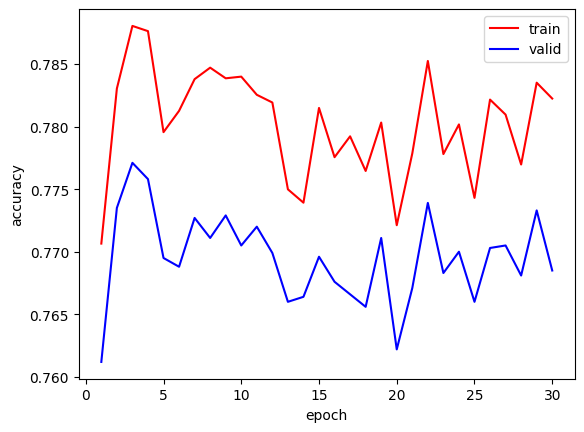

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int8)


              precision    recall  f1-score   support

     T-Shirt       0.78      0.68      0.73      1000
     Trouser       0.98      0.92      0.95      1000
    Pullover       0.56      0.74      0.64      1000
       Dress       0.83      0.77      0.80      1000
        Coat       0.72      0.51      0.59      1000
      Sandal       0.87      0.91      0.89      1000
       Shirt       0.38      0.49      0.43      1000
     Sneaker       0.87      0.89      0.88      1000
         Bag       0.95      0.88      0.91      1000
  Ankle Boot       0.93      0.90      0.91      1000

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.77     10000
weighted avg       0.79      0.77      0.77     10000



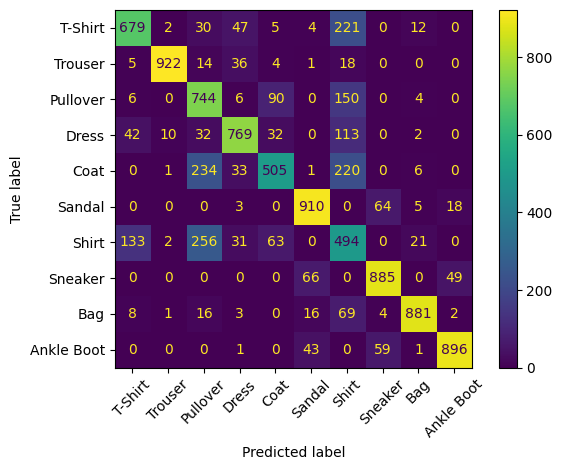

In [25]:
classifier_6 = classifier_generator(Classifier_Conv, 64, model_orig,
                                    0.2, 30, 100, 'Adam classifier', 1e-3, train_set_orig, valid_set_orig)